## Customer Model Behavior Analysis
---

* customer model behavior
    * [force plot](https://docs.google.com/document/d/1_xQoyimEkDi-Guoml2MxS6wXQATmy8D27iSsQ4LIAzY/edit) for missing fraud_score_1
    * [detailed feature importance](https://docs.google.com/spreadsheets/d/1YZEXwaCuxTTXL5skdSz_ZdIZujr2kUhQaK076Sy4KK4/edit#gid=0)
    
  OOT samples in 2021 from dropping fraud_score_1 entirely and changing missing name_address_correlation to 1

In [1]:
import sys, os, json
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from tqdm import tqdm
import copy

from smart_open import open
import pickle as pkl
import src.monitoring.utils as mu

from src.utils import scale_scores
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

plt.style.use("seaborn")

In [2]:
# load models

with open("../../config.json", "r") as f:
    config = json.load(f)
    mpaths = config["monitoring_config"]["model_paths"]
    
with open(mpaths["incumbent_model"], "rb") as f:
    incumbent_model = pkl.load(f)
    
with open(mpaths["customer_refitted_2021Q1"], "rb") as f:
    refitted_model = pkl.load(f)

In [3]:
# # load prod data
# output_path = f"s3://sofi-data-science/jxu/data_dump/money-analysis/prod-2021-08-02.parquet"
# df = pd.read_parquet(output_path)

# # clean data
# for col in ["created_dt", "updated_dt", "last_checked_date", "last_checked_date_max"]:
#     df[col] = pd.to_datetime(df[col])

In [4]:
mconfig = config["monitoring_config"]
locals().update(mconfig)   # this would set k-v pairs in mconfig as local variables
print(mconfig.keys())

# load dev side data
static_sample_dates = [pd.to_datetime(d) for d in monitoring_dates]
date_sample_end = pd.to_datetime(date_sample_end)

df = pd.read_feather(dev_df_path)
test_df = df[df.is_static 
             & (df.sample_date.isin(monitoring_dates))]

dict_keys(['mmonth', 'dev_df_path', 'monitoring_dates', 'prod_data_dates', 'data_output_path', 'artifact_path', 'date_sample_start', 'date_sample_end', 'model_paths', 'prev_test_df_path', 'modeling_df_path', 'test_df_path', 'prod_dfs_path'])


In [5]:
df = test_df[test_df.sample_date == pd.to_datetime("2021-06-01")].copy()

In [6]:
def get_risk_groups(serie):
    return pd.cut(serie.round(), [300, 474, 510, 560, 600, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

def get_risk_groups_refitted(serie):
    return pd.cut(serie.round(), [300, 520, 550, 570, 590, 850], 
                  right=True, labels=[f'RG{i}' for i in range(1, 6)],
                  include_lowest=True)

In [7]:
# other setups
features = incumbent_model.feature_name_

df = mu.prep_customer_data(df)

df["pred_incumbent"] = incumbent_model.predict_proba(df[features])[:,1]
df["pred_refitted"] = refitted_model.predict_proba(df[features])[:,1]

df["score_incumbent"] = mu.scale_scores(df["pred_incumbent"])
df["score_refitted"] = mu.scale_scores(df["pred_refitted"])

df["rg_incumbent"] = get_risk_groups(df["score_incumbent"])
df["rg_refitted"] = get_risk_groups_refitted(df["score_refitted"])

#### Drop unwanted scores

In [8]:
# # there are exceptionally large amount of users having these scores: 
# # 659.267777    70202
# # 661.184667    19965
# # 660.923098    13207
# # find out why
# scores_ = df.model_score.value_counts().index[:4]
# scores_
# df_ = df[df.model_score.isin(scores_)]
# df_ = df_[features+["model_score"]].drop_duplicates()

In [9]:
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

In [10]:
# for s in scores_:
#     print("score: ", s)
#     display(df_[df_.model_score == s])

In [11]:
# # drop data that is empty for all fields
# print(df.shape)
# df.dropna(subset=features, how="all", inplace=True)
# df = df[~df.model_score.isin(scores_)]
# print(df.shape)

In [12]:
df.head()

,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_amount,external_account_number,real_ending_balance,user_id,sofi_employee_ind,dtc,...,party_id,is_active,fico_adjusted,fico_adjusted_pred,pred_incumbent,pred_refitted,score_incumbent,score_refitted,rg_incumbent,rg_refitted
10606129,NaT,141546.0,410000096715,None,NaN,None,NaN,855,False,None,...,855,False,NaN,NaN,0.237114,0.438784,595.939068,624.362640,RG4,RG5
10606130,2021-05-31 00:05:26,5618.0,410011698790,IIPD,0.00,,228.63,257,False,None,...,257,False,768.0,-768.0,0.022277,0.020835,515.423090,513.315192,RG3,RG1
10606131,2021-05-30 07:00:48,90.0,410001537288,DWTRF,-0.33,,283491.89,273,False,None,...,273,True,767.0,-767.0,0.000696,0.000370,407.960761,388.465583,RG1,RG1
10606132,2020-04-28 04:46:22,103.0,410002729647,ACHDWIN,-0.65,,1106.44,299,False,None,...,299,False,799.0,-799.0,0.000493,0.008410,397.307481,484.972425,RG1,RG1
10606133,NaT,107.0,410000276182,None,NaN,None,NaN,305,False,None,...,305,False,NaN,NaN,0.133862,0.357837,574.411334,613.927501,RG4,RG5


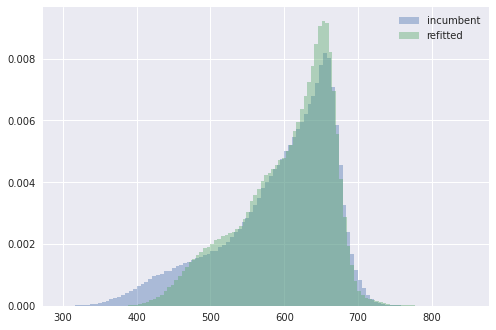

In [13]:
df.score_incumbent.hist(bins=100, alpha=0.4, density=True, label="incumbent")
df.score_refitted.hist(bins=100, alpha=0.4, density=True, label="refitted")
plt.legend()

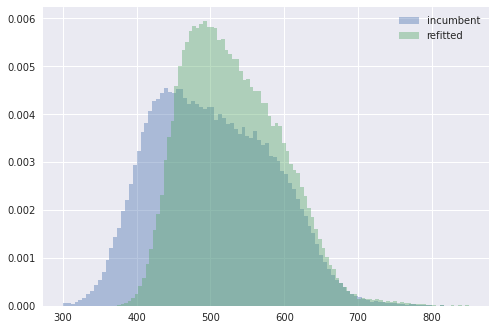

In [14]:
df[df.is_active].score_incumbent.hist(bins=100, alpha=0.4, density=True, label="incumbent")
df[df.is_active].score_refitted.hist(bins=100, alpha=0.4, density=True, label="refitted")
plt.legend()

### fraud_score_1
---

after moving from sigma 1 to 2, fraud_score_1 is/will be discontinued. Look at impact if a fraud_score_1 is from available to missing.

In [15]:
# take subset with available missing fraud_score_1
# df_w_fs1 = df[~df.fraud_score_1.isna()]
# df_wo_fs1 = df[df.fraud_score_1.isna()]
cond = (~df.fraud_score_1.isna()) & (~df.fraud_score_2.isna())
df_w_fs1 = df[cond]

# MISSING FRAUD_SCORE_1
# now create a copy of df_w_fs1 and map over the fraud score 1
df_wo_fs1 = df_w_fs1.copy()
df_wo_fs1.fraud_score_1 = np.nan

# re score df_wo_fs1
df_wo_fs1["pred_incumbent"] = incumbent_model.predict_proba(df_wo_fs1[features])[:,1]
df_wo_fs1["pred_refitted"] = refitted_model.predict_proba(df_wo_fs1[features])[:,1]

df_wo_fs1["score_incumbent"] = mu.scale_scores(df_wo_fs1["pred_incumbent"])
df_wo_fs1["score_refitted"] = mu.scale_scores(df_wo_fs1["pred_refitted"])

df_wo_fs1["rg_incumbent"] = get_risk_groups(df_wo_fs1["score_incumbent"])
df_wo_fs1["rg_refitted"] = get_risk_groups_refitted(df_wo_fs1["score_refitted"])

# MISSING FRAUD_SCORE_2
# now create a copy of df_w_fs1 and map over the fraud score 2
df_wo_fs2 = df_w_fs1.copy()
df_wo_fs2.fraud_score_2 = np.nan

# re score df_wo_fs1
df_wo_fs2["pred_incumbent"] = incumbent_model.predict_proba(df_wo_fs2[features])[:,1]
df_wo_fs2["pred_refitted"] = refitted_model.predict_proba(df_wo_fs2[features])[:,1]

df_wo_fs2["score_incumbent"] = mu.scale_scores(df_wo_fs2["pred_incumbent"])
df_wo_fs2["score_refitted"] = mu.scale_scores(df_wo_fs2["pred_refitted"])

df_wo_fs2["rg_incumbent"] = get_risk_groups(df_wo_fs2["score_incumbent"])
df_wo_fs2["rg_refitted"] = get_risk_groups_refitted(df_wo_fs2["score_refitted"])

# MISSING FRAUD_SCORE_1 AND 2
# now create a copy of df_wo_fs1 and map over the fraud score 2
df_wo_fs12 = df_wo_fs1.copy()
df_wo_fs12.fraud_score_2 = np.nan

# re score df_wo_fs1
df_wo_fs12["pred_incumbent"] = incumbent_model.predict_proba(df_wo_fs12[features])[:,1]
df_wo_fs12["pred_refitted"] = refitted_model.predict_proba(df_wo_fs12[features])[:,1]

df_wo_fs12["score_incumbent"] = mu.scale_scores(df_wo_fs12["pred_incumbent"])
df_wo_fs12["score_refitted"] = mu.scale_scores(df_wo_fs12["pred_refitted"])

df_wo_fs12["rg_incumbent"] = get_risk_groups(df_wo_fs12["score_incumbent"])
df_wo_fs12["rg_refitted"] = get_risk_groups_refitted(df_wo_fs12["score_refitted"])

display(df_wo_fs12.shape, df_wo_fs12.shape)

(748722, 104)

(748722, 104)

In [16]:
df_w_fs1[df_w_fs1.fraud_score_1>0.9].head()

,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_amount,external_account_number,real_ending_balance,user_id,sofi_employee_ind,dtc,...,party_id,is_active,fico_adjusted,fico_adjusted_pred,pred_incumbent,pred_refitted,score_incumbent,score_refitted,rg_incumbent,rg_refitted
10606337,NaT,3397.0,410001646015,None,NaN,None,NaN,10003,False,None,...,10003,False,797.0,-797.0,0.066227,0.233492,550.411202,595.318739,RG3,RG5
10608405,2021-05-03 05:02:58,82073.0,410004746407,ACHDWIN,-1900.0,,2917.29,133210,False,None,...,133210,True,NaN,NaN,0.000930,0.004025,416.904298,462.129112,RG1,RG1
10609863,2021-02-12 18:01:12,189338.0,410000294326,ACHDW,-150.0,000769942738,328.19,233355,False,None,...,233355,False,NaN,NaN,0.003592,0.010315,458.612425,491.323260,RG1,RG1
10612215,2021-04-09 19:56:06,363634.0,410006722730,DWBILLPAY,-499.0,************6158,58.20,406399,False,None,...,406399,False,774.0,-774.0,0.026703,0.012385,521.146368,497.022802,RG3,RG1
10613078,NaT,444570.0,410010755084,None,NaN,None,NaN,486918,False,None,...,486918,False,652.0,-652.0,0.250308,0.283690,598.145051,603.406017,RG4,RG5


In [17]:
i = 10608405
df_exp = pd.concat([df_w_fs1.loc[i][features+["score_incumbent", "score_refitted"]].to_frame(), 
           df_wo_fs1.loc[i][features+["score_incumbent", "score_refitted"]].to_frame()],
          axis=1).T
df_exp[["fraud_score_1", "score_incumbent", "score_refitted"]]  # fraud_score_1: 0.0266-> nan; no change

,fraud_score_1,score_incumbent,score_refitted
10608405,0.9365,416.904298,462.129112
10608405,NaN,420.55956,451.662742


In [18]:
def plot_difference(expected_sequence, actual_sequence, 
                    figsize=(9,7), bins=10, label='exp - actual', title=''):
    """ Plot the distr of difference of two sequences 
    Two sequences should have the same size
    """
    assert(len(expected_sequence) == len(actual_sequence))
    fig = plt.figure(figsize=figsize)
    seq = np.array(expected_sequence) - np.array(actual_sequence)
    plt.hist(seq, alpha=0.6, bins=bins, label=label)
    plt.legend()
    plt.title(title)
    return fig

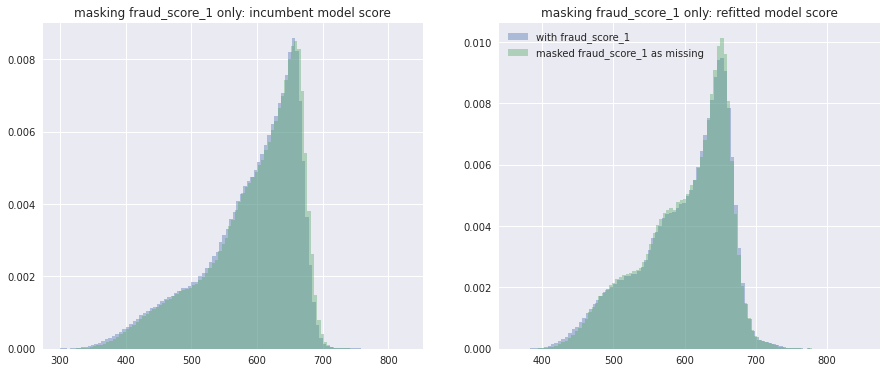

In [19]:
score_col = "score_incumbent"
fig, axs = plt.subplots(1,2,figsize=(15,6))

df_w_fs1[score_col].hist(bins=100, alpha=0.4, ax=axs[0],
                         density=True, label="with fraud_score_1")
df_wo_fs1[score_col].hist(bins=100, alpha=0.4, ax=axs[0],
                          density=True, label="masked fraud_score_1 as missing")
axs[0].set_title("masking fraud_score_1 only: incumbent model score")

score_col = "score_refitted"
df_w_fs1[score_col].hist(bins=100, alpha=0.4, ax=axs[1],
                         density=True, label="with fraud_score_1")
df_wo_fs1[score_col].hist(bins=100, alpha=0.4, ax=axs[1],
                          density=True, label="masked fraud_score_1 as missing")
axs[1].set_title("masking fraud_score_1 only: refitted model score")

plt.legend()
plt.show()

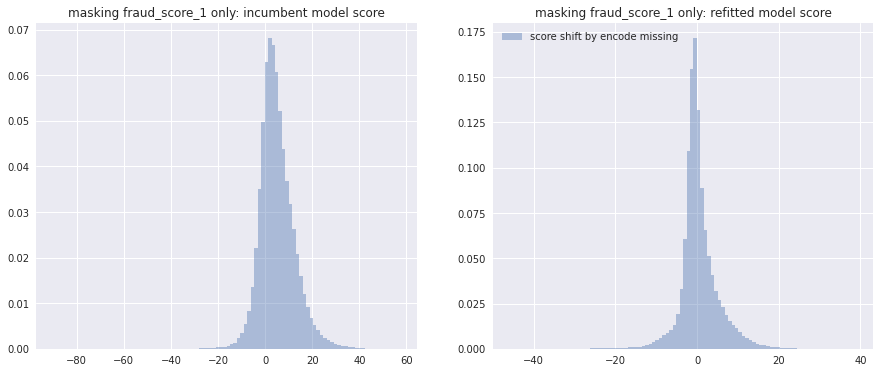

In [20]:
score_col = "score_incumbent"
fig, axs = plt.subplots(1,2,figsize=(15,6))

score_diff = df_wo_fs1[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=0.4, ax=axs[0],
                         density=True, label="score shift by encode missing")
axs[0].set_title("masking fraud_score_1 only: incumbent model score")

score_col = "score_refitted"
score_diff = df_wo_fs1[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=0.4, ax=axs[1],
                         density=True, label="score shift by encode missing")
axs[1].set_title("masking fraud_score_1 only: refitted model score")

plt.legend()
plt.show()

#### the incumbent model penalize missing fraud_score_1 more

What is the cause?
* is the information included in fraud score 2?
    * let's mask fs2 also and take a look
* how about the active user segment?

#### Active population

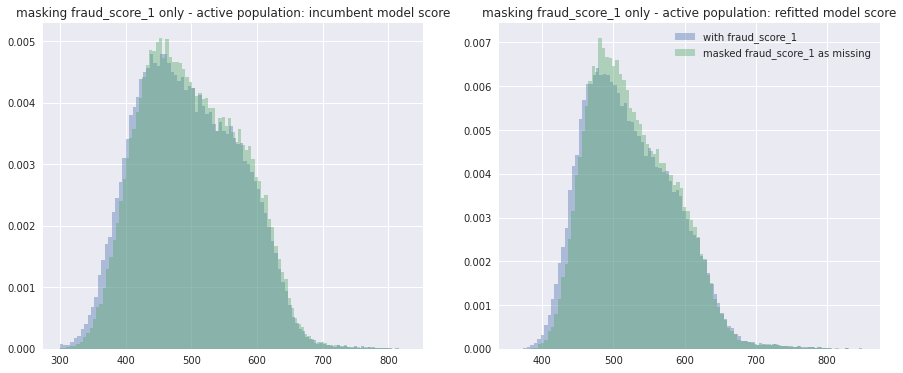

In [21]:
score_col = "score_incumbent"
fig, axs = plt.subplots(1,2,figsize=(15,6))
df_w_fs1_ = df_w_fs1[df_w_fs1.is_active]
df_wo_fs1_ = df_wo_fs1[df_wo_fs1.is_active]

df_w_fs1_[score_col].hist(bins=100, alpha=0.4, ax=axs[0],
                         density=True, label="with fraud_score_1")
df_wo_fs1_[score_col].hist(bins=100, alpha=0.4, ax=axs[0],
                          density=True, label="masked fraud_score_1 as missing")
axs[0].set_title("masking fraud_score_1 only - active population: incumbent model score")

score_col = "score_refitted"
df_w_fs1_[score_col].hist(bins=100, alpha=0.4, ax=axs[1],
                         density=True, label="with fraud_score_1")
df_wo_fs1_[score_col].hist(bins=100, alpha=0.4, ax=axs[1],
                          density=True, label="masked fraud_score_1 as missing")
axs[1].set_title("masking fraud_score_1 only - active population: refitted model score")

plt.legend()
plt.show()

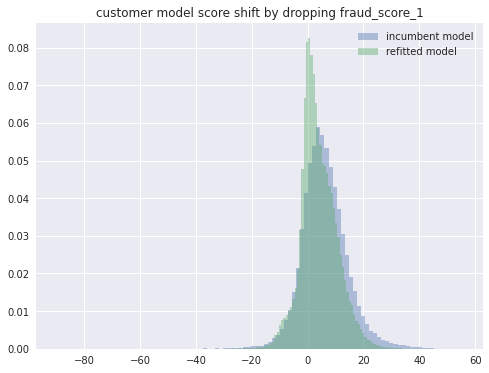

In [22]:
score_col = "score_incumbent"
fig = plt.figure(figsize=(8,6))
df_w_fs1_ = df_w_fs1[df_w_fs1.is_active]
df_wo_fs1_ = df_wo_fs1[df_wo_fs1.is_active]

score_diff = df_wo_fs1_[score_col] - df_w_fs1_[score_col]
score_diff.hist(bins=100, alpha=0.4, 
                         density=True, label="incumbent model")
# axs[0].set_title("masking fraud_score_1 only - active population: incumbent model score")

score_col = "score_refitted"
score_diff = df_wo_fs1_[score_col] - df_w_fs1_[score_col]
score_diff.hist(bins=100, alpha=0.4, 
                         density=True, label="refitted model")
# axs[0].set_title("masking fraud_score_1 only - active population: refitted model score")

plt.title("customer model score shift by dropping fraud_score_1")
plt.legend()
plt.show()

#### What is we drop fraud_score_2 as well?

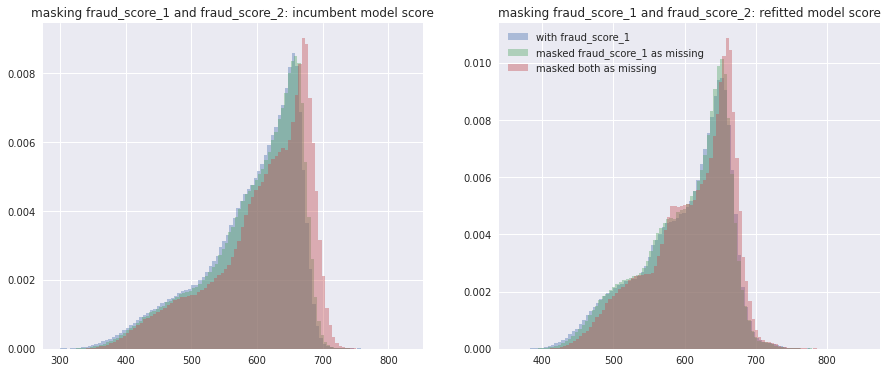

In [23]:
score_col = "score_incumbent"
fig, axs = plt.subplots(1,2,figsize=(15,6))

df_w_fs1[score_col].hist(bins=100, alpha=0.4, ax=axs[0],
                         density=True, label="with fraud_score_1")
df_wo_fs1[score_col].hist(bins=100, alpha=0.4, ax=axs[0],
                          density=True, label="masked fraud_score_1 as missing")
df_wo_fs12[score_col].hist(bins=100, alpha=0.4, ax=axs[0],
                          density=True, label="masked both as missing")
axs[0].set_title("masking fraud_score_1 and fraud_score_2: incumbent model score")

score_col = "score_refitted"
df_w_fs1[score_col].hist(bins=100, alpha=0.4, ax=axs[1],
                         density=True, label="with fraud_score_1")
df_wo_fs1[score_col].hist(bins=100, alpha=0.4, ax=axs[1],
                          density=True, label="masked fraud_score_1 as missing")
df_wo_fs12[score_col].hist(bins=100, alpha=0.4, ax=axs[1],
                          density=True, label="masked both as missing")
axs[1].set_title("masking fraud_score_1 and fraud_score_2: refitted model score")

plt.legend()
plt.show()

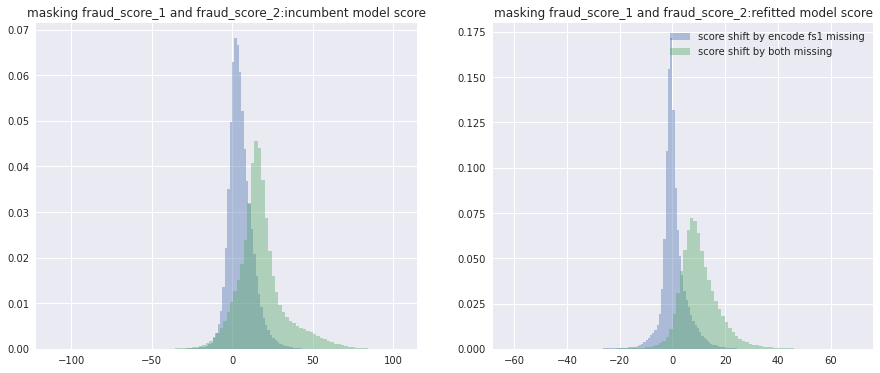

In [24]:
score_col = "score_incumbent"
fig, axs = plt.subplots(1,2,figsize=(15,6))

score_diff = df_wo_fs1[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=0.4, ax=axs[0],
                         density=True, label="score shift by encode fs1 missing")

score_diff = df_wo_fs12[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=0.4, ax=axs[0],
                         density=True, label="score shift by both missing")

axs[0].set_title("masking fraud_score_1 and fraud_score_2:incumbent model score")

score_col = "score_refitted"
score_diff = df_wo_fs1[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=0.4, ax=axs[1],
                         density=True, label="score shift by encode fs1 missing")

score_diff = df_wo_fs12[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=0.4, ax=axs[1],
                         density=True, label="score shift by both missing")
axs[1].set_title("masking fraud_score_1 and fraud_score_2:refitted model score")

plt.legend()
plt.show()

#### How about only fraud_score_2?

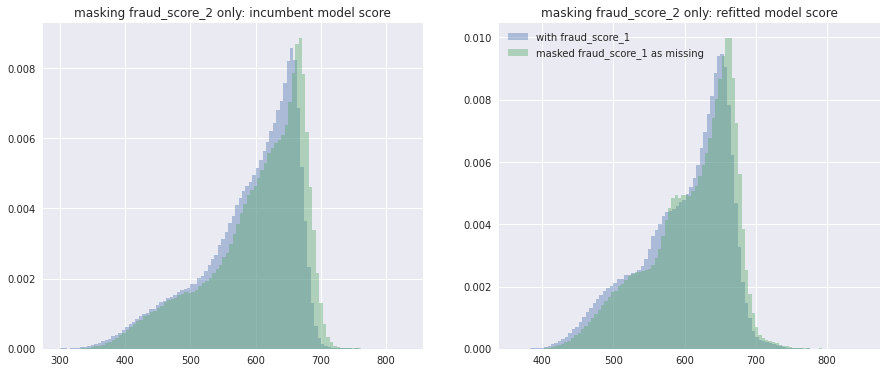

In [25]:
score_col = "score_incumbent"
fig, axs = plt.subplots(1,2,figsize=(15,6))

df_w_fs1[score_col].hist(bins=100, alpha=0.4, ax=axs[0],
                         density=True, label="with fraud_score_1")
df_wo_fs2[score_col].hist(bins=100, alpha=0.4, ax=axs[0],
                          density=True, label="masked fraud_score_1 as missing")
axs[0].set_title("masking fraud_score_2 only: incumbent model score")

score_col = "score_refitted"
df_w_fs1[score_col].hist(bins=100, alpha=0.4, ax=axs[1],
                         density=True, label="with fraud_score_1")
df_wo_fs2[score_col].hist(bins=100, alpha=0.4, ax=axs[1],
                          density=True, label="masked fraud_score_1 as missing")
axs[1].set_title("masking fraud_score_2 only: refitted model score")

plt.legend()
plt.show()

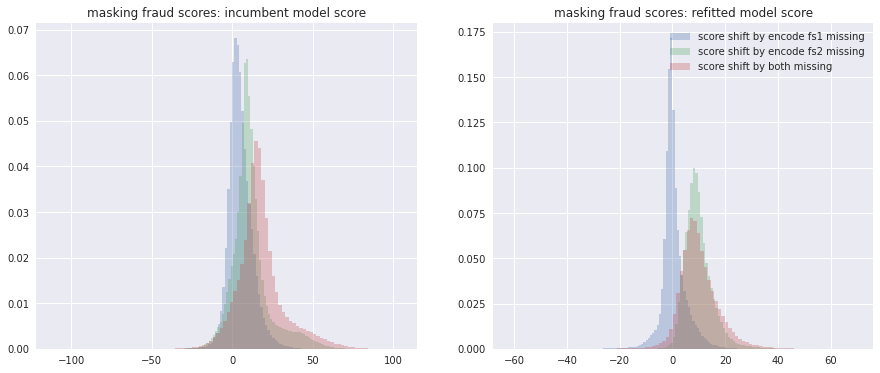

In [26]:
score_col = "score_incumbent"
alpha = 0.3
fig, axs = plt.subplots(1,2,figsize=(15,6))

score_diff = df_wo_fs1[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=alpha, ax=axs[0],
                         density=True, label="score shift by encode fs1 missing")

score_diff = df_wo_fs2[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=alpha, ax=axs[0],
                         density=True, label="score shift by encode fs2 missing")

score_diff = df_wo_fs12[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=alpha, ax=axs[0],
                         density=True, label="score shift by both missing")

axs[0].set_title("masking fraud scores: incumbent model score")

score_col = "score_refitted"
score_diff = df_wo_fs1[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=alpha, ax=axs[1],
                         density=True, label="score shift by encode fs1 missing")

score_diff = df_wo_fs2[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=alpha, ax=axs[1],
                         density=True, label="score shift by encode fs2 missing")
axs[1].set_title("masking fraud scores: refitted model score")

score_diff = df_wo_fs12[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=alpha, ax=axs[1],
                         density=True, label="score shift by both missing")


plt.legend()
plt.show()

#### By activeness

In [27]:
# take subset with available missing fraud_score_1
# df_w_fs1 = df[~df.fraud_score_1.isna()]
# df_wo_fs1 = df[df.fraud_score_1.isna()]
cond = (~df.fraud_score_1.isna()) & (~df.fraud_score_2.isna()) & (df.is_active)
df_w_fs1 = df[cond]

# MISSING FRAUD_SCORE_1
# now create a copy of df_w_fs1 and map over the fraud score 1
df_wo_fs1 = df_w_fs1.copy()
df_wo_fs1.fraud_score_1 = np.nan

# re score df_wo_fs1
df_wo_fs1["pred_incumbent"] = incumbent_model.predict_proba(df_wo_fs1[features])[:,1]
df_wo_fs1["pred_refitted"] = refitted_model.predict_proba(df_wo_fs1[features])[:,1]

df_wo_fs1["score_incumbent"] = mu.scale_scores(df_wo_fs1["pred_incumbent"])
df_wo_fs1["score_refitted"] = mu.scale_scores(df_wo_fs1["pred_refitted"])



# MISSING FRAUD_SCORE_2
# now create a copy of df_w_fs1 and map over the fraud score 2
df_wo_fs2 = df_w_fs1.copy()
df_wo_fs2.fraud_score_2 = np.nan

# re score df_wo_fs1
df_wo_fs2["pred_incumbent"] = incumbent_model.predict_proba(df_wo_fs2[features])[:,1]
df_wo_fs2["pred_refitted"] = refitted_model.predict_proba(df_wo_fs2[features])[:,1]

df_wo_fs2["score_incumbent"] = mu.scale_scores(df_wo_fs2["pred_incumbent"])
df_wo_fs2["score_refitted"] = mu.scale_scores(df_wo_fs2["pred_refitted"])


# MISSING FRAUD_SCORE_1 AND 2
# now create a copy of df_wo_fs1 and map over the fraud score 2
df_wo_fs12 = df_wo_fs1.copy()
df_wo_fs12.fraud_score_2 = np.nan

# re score df_wo_fs1
df_wo_fs12["pred_incumbent"] = incumbent_model.predict_proba(df_wo_fs12[features])[:,1]
df_wo_fs12["pred_refitted"] = refitted_model.predict_proba(df_wo_fs12[features])[:,1]

df_wo_fs12["score_incumbent"] = mu.scale_scores(df_wo_fs12["pred_incumbent"])
df_wo_fs12["score_refitted"] = mu.scale_scores(df_wo_fs12["pred_refitted"])

display(df_wo_fs12.shape, df_wo_fs12.shape)

(92627, 104)

(92627, 104)

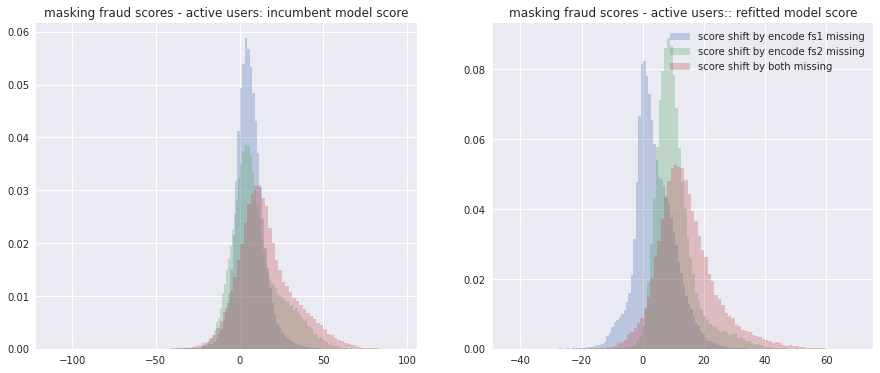

In [28]:
score_col = "score_incumbent"
alpha = 0.3
fig, axs = plt.subplots(1,2,figsize=(15,6))

score_diff = df_wo_fs1[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=alpha, ax=axs[0],
                         density=True, label="score shift by encode fs1 missing")

score_diff = df_wo_fs2[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=alpha, ax=axs[0],
                         density=True, label="score shift by encode fs2 missing")

score_diff = df_wo_fs12[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=alpha, ax=axs[0],
                         density=True, label="score shift by both missing")

axs[0].set_title("masking fraud scores - active users: incumbent model score")

score_col = "score_refitted"
score_diff = df_wo_fs1[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=alpha, ax=axs[1],
                         density=True, label="score shift by encode fs1 missing")

score_diff = df_wo_fs2[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=alpha, ax=axs[1],
                         density=True, label="score shift by encode fs2 missing")
axs[1].set_title("masking fraud scores - active users:: refitted model score")

score_diff = df_wo_fs12[score_col] - df_w_fs1[score_col]
score_diff.hist(bins=100, alpha=alpha, ax=axs[1],
                         density=True, label="score shift by both missing")


plt.legend()
plt.show()

In [29]:
# score_diff = df["score_refitted"] - df["score_incumbent"]
# score_diff.hist(bins=100, alpha=0.4,
#                          density=True, label="score change after refitting")

# score_diff = df[df.is_active]["score_refitted"] - df[df.is_active]["score_incumbent"]
# score_diff.hist(bins=100, alpha=0.4,
#                          density=True, label="score change after refitting")

#### Is the size of shift of fraud_score_1 effect by what score it shifted from?

In [30]:
# take subset with available missing fraud_score_1
# df_w_fs1 = df[~df.fraud_score_1.isna()]
# df_wo_fs1 = df[df.fraud_score_1.isna()]
cond = (~df.fraud_score_1.isna()) & (~df.fraud_score_2.isna())
df_w_fs1 = df[cond]

# MISSING FRAUD_SCORE_1
# now create a copy of df_w_fs1 and map over the fraud score 1
df_wo_fs1 = df_w_fs1.copy()
df_wo_fs1.fraud_score_1 = np.nan

# re score df_wo_fs1
df_wo_fs1["pred_incumbent"] = incumbent_model.predict_proba(df_wo_fs1[features])[:,1]
df_wo_fs1["pred_refitted"] = refitted_model.predict_proba(df_wo_fs1[features])[:,1]

df_wo_fs1["score_incumbent"] = mu.scale_scores(df_wo_fs1["pred_incumbent"])
df_wo_fs1["score_refitted"] = mu.scale_scores(df_wo_fs1["pred_refitted"])

df_wo_fs1["rg_incumbent"] = get_risk_groups(df_wo_fs1["score_incumbent"])
df_wo_fs1["rg_refitted"] = get_risk_groups_refitted(df_wo_fs1["score_refitted"])

# MISSING FRAUD_SCORE_2
# now create a copy of df_w_fs1 and map over the fraud score 2
df_wo_fs2 = df_w_fs1.copy()
df_wo_fs2.fraud_score_2 = np.nan

# re score df_wo_fs1
df_wo_fs2["pred_incumbent"] = incumbent_model.predict_proba(df_wo_fs2[features])[:,1]
df_wo_fs2["pred_refitted"] = refitted_model.predict_proba(df_wo_fs2[features])[:,1]

df_wo_fs2["score_incumbent"] = mu.scale_scores(df_wo_fs2["pred_incumbent"])
df_wo_fs2["score_refitted"] = mu.scale_scores(df_wo_fs2["pred_refitted"])

df_wo_fs2["rg_incumbent"] = get_risk_groups(df_wo_fs2["score_incumbent"])
df_wo_fs2["rg_refitted"] = get_risk_groups_refitted(df_wo_fs2["score_refitted"])

# MISSING FRAUD_SCORE_1 AND 2
# now create a copy of df_wo_fs1 and map over the fraud score 2
df_wo_fs12 = df_wo_fs1.copy()
df_wo_fs12.fraud_score_2 = np.nan

# re score df_wo_fs1
df_wo_fs12["pred_incumbent"] = incumbent_model.predict_proba(df_wo_fs12[features])[:,1]
df_wo_fs12["pred_refitted"] = refitted_model.predict_proba(df_wo_fs12[features])[:,1]

df_wo_fs12["score_incumbent"] = mu.scale_scores(df_wo_fs12["pred_incumbent"])
df_wo_fs12["score_refitted"] = mu.scale_scores(df_wo_fs12["pred_refitted"])

df_wo_fs12["rg_incumbent"] = get_risk_groups(df_wo_fs12["score_incumbent"])
df_wo_fs12["rg_refitted"] = get_risk_groups_refitted(df_wo_fs12["score_refitted"])

display(df_wo_fs12.shape, df_wo_fs12.shape)

(748722, 104)

(748722, 104)

<AxesSubplot:>

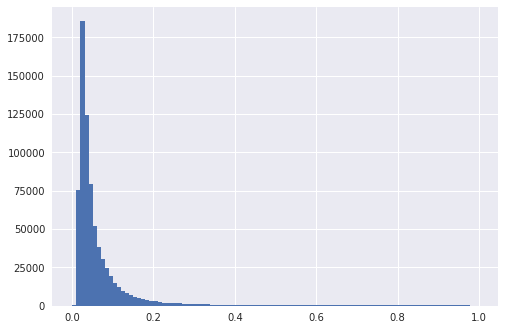

In [31]:
df_w_fs1.fraud_score_1.hist(bins=100)

In [32]:
trees = incumbent_model.booster_.trees_to_dataframe()

<AxesSubplot:>

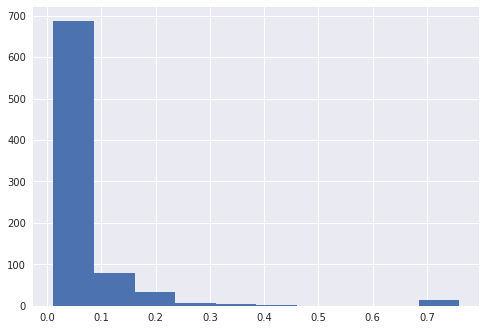

In [33]:
trees[trees.split_feature=="fraud_score_1"].threshold.hist()

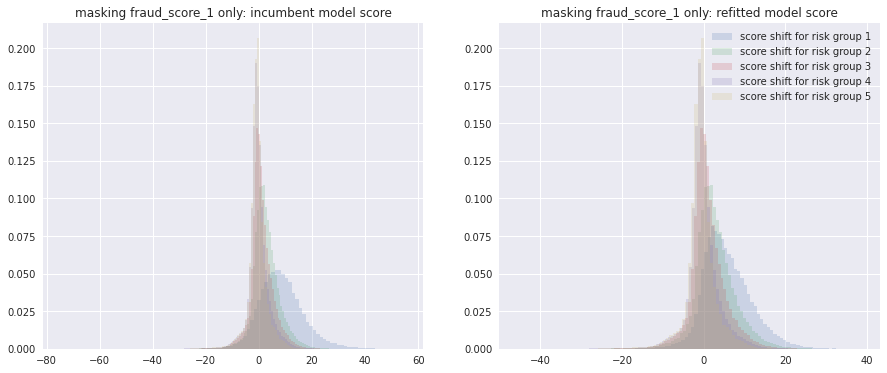

In [34]:
score_col = "score_incumbent"
fig, axs = plt.subplots(1,2,figsize=(15,6))
alpha = 0.2

conds = [(df_w_fs1.rg_incumbent == f"RG{i}") for i in range(1,6)]

for i,cond in enumerate(conds):

    score_diff = df_wo_fs1[cond][score_col] - df_w_fs1[cond][score_col]
    score_diff.hist(bins=100, alpha=alpha, ax=axs[0],
                             density=True, label=f"score shift for risk group {i+1}")
    axs[0].set_title("masking fraud_score_1 only: incumbent model score")

    score_col = "score_refitted"
    score_diff = df_wo_fs1[cond][score_col] - df_w_fs1[cond][score_col]
    score_diff.hist(bins=100, alpha=alpha, ax=axs[1],
                             density=True, label=f"score shift for risk group {i+1}")
    axs[1].set_title("masking fraud_score_1 only: refitted model score")

plt.legend()
plt.show()

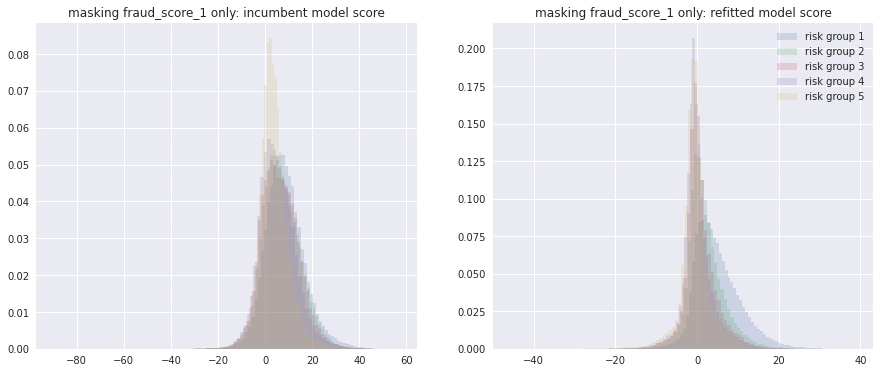

In [35]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
alpha = 0.2
# conds = [(df_w_fs1.fraud_score_1.between(lower, upper))
#          for (lower, upper) in [(0, 0.1), (0.1,0.2),(0.2,0.3),(0.3,0.5),(0.5,1)]]

conds = [(df_w_fs1.rg_refitted == f"RG{i}") for i in range(1,6)]

for i in range(1,6):
    score_col = "score_incumbent"
    cond = df_w_fs1.rg_incumbent == f"RG{i}"
    score_diff = df_wo_fs1[cond][score_col] - df_w_fs1[cond][score_col]
    score_diff.hist(bins=100, alpha=alpha, ax=axs[0],
                             density=True, label=f"risk group {i}")
    axs[0].set_title("masking fraud_score_1 only: incumbent model score")

    score_col = "score_refitted"
    cond = df_w_fs1.rg_refitted == f"RG{i}"
    score_diff = df_wo_fs1[cond][score_col] - df_w_fs1[cond][score_col]
    score_diff.hist(bins=100, alpha=alpha, ax=axs[1],
                             density=True, label=f"risk group {i}")
    axs[1].set_title("masking fraud_score_1 only: refitted model score")

plt.legend()
plt.show()

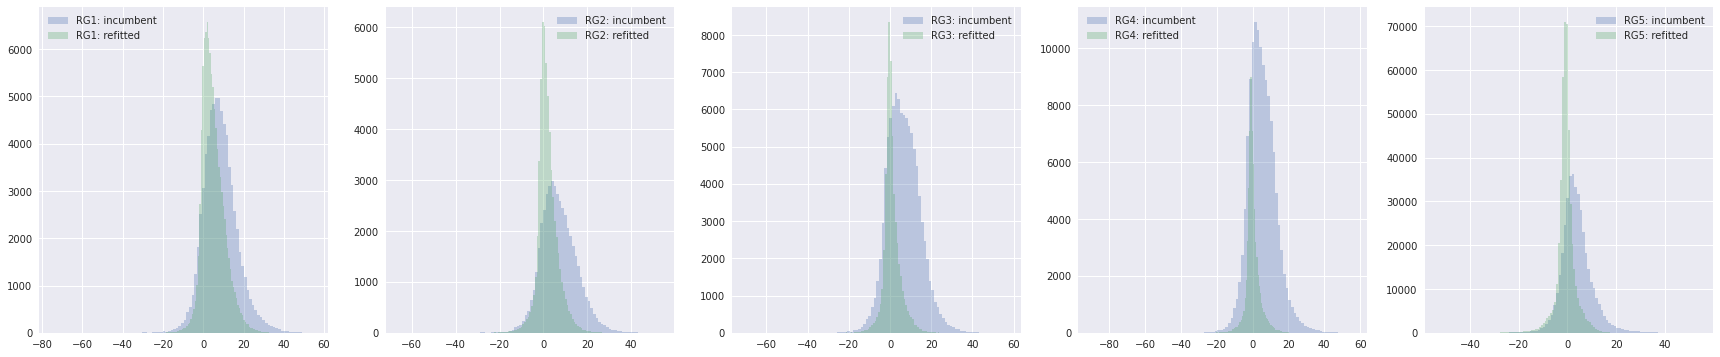

In [36]:
fig, axs = plt.subplots(1, 5, figsize=(30, 6))
for i, rg in enumerate(["RG1", "RG2", "RG3", "RG4", "RG5"]):
    exp_seq = df_w_fs1[df_w_fs1.rg_incumbent==rg].score_incumbent
    act_seq = df_wo_fs1[df_w_fs1.rg_incumbent==rg].score_incumbent
    seq = np.array(act_seq) - np.array(exp_seq)
    axs[i].hist(seq, alpha=0.3, bins=100, label=f'{rg}: incumbent')
    axs[i].legend()

# fig, axs = plt.subplots(1, 5, figsize=(30, 6))
for i, rg in enumerate(["RG1", "RG2", "RG3", "RG4", "RG5"]):
    exp_seq = df_w_fs1[df_w_fs1.rg_refitted==rg].score_refitted
    act_seq = df_wo_fs1[df_w_fs1.rg_refitted==rg].score_refitted
    seq = np.array(act_seq) - np.array(exp_seq)
    axs[i].hist(seq, alpha=0.3, bins=100, label=f'{rg}: refitted')
    axs[i].legend()

plt.show()